### **PINN Exercise!**

Solve the following problem with a PINN
$$
\begin{cases}
- u'' = \sin(\pi x) & \text { in } (0,2),\\
u(0) = u(2) = 0 \text{ strong boundary condition}.  
\end{cases}
$$
Take inspiration from the exercises we have done in class.

In this case, the exact solution is
$$
u(x) = \frac{1}{\pi^2}\sin(\pi x).
$$

In [1]:
#### starting stuff ####

import torch
import torch.nn as nn
from torch.autograd import Variable

import numpy as np

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.input_layer = nn.Linear(1,5)
        self.hidden_layer1 = nn.Linear(5,5)
        self.hidden_layer2 = nn.Linear(5,5)
        self.hidden_layer3 = nn.Linear(5,5)
        self.hidden_layer4 = nn.Linear(5,5)
        self.output_layer = nn.Linear(5,1)

    def forward(self, x):
        input = x
        layer1_out = torch.sigmoid(self.input_layer(input))
        layer2_out = torch.sigmoid(self.hidden_layer1(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer2(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer3(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer4(layer4_out))
        output = self.output_layer(layer5_out)
        return output # Another wat output*x*(x-2) or....

In [3]:
### (2) Model
seed = 0
torch.manual_seed(seed)
net = Net()
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters())

In [4]:
## PDE as loss function. Thus would use the network which we call as u_theta
def R(x, net):
    u = net(x) # the dependent variable u is given by the network based on independent variables x,t
    
    ## Based on our R = du/dx - 2du/dt - u, we need du/dx and du/dt
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0] 
    
    f = torch.Tensor(np.sin(3.14*x.detach().numpy()))
    pde = -u_xx - f # This is the definition of my pdee
    
    return pde

In [5]:
## Data from Boundary Conditions
## BC just gives us datapoints for training

# BC tells us that for any x in range[0,2] and time=0, the value of u is given by 6e^(-3x)
# Take say 500 random numbers of x
x_bc = np.zeros((2,1))
x_bc[1] = 2 # .... Put the boundary condition 0 & 2
u_bc = np.zeros((2,1)) # Value summing on the boundary condition

In [6]:
### (3) Training / Fitting
iterations = 10000
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on boundary conditions
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False)
    net_bc_out = net(pt_x_bc) # output of u(x)
    mse_u = mse_cost_function(net_bc_out, pt_u_bc)
    
    # Loss based on PDE
    x_collocation = np.random.uniform(low=0.0, high=2.0, size=(500,1)) # Collocation point allover the domain
    all_zeros = np.zeros((500,1))
    
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False)
    f_out = R(pt_x_collocation, net) # output of R(x)
    mse_f = mse_cost_function(f_out, pt_all_zeros) # Set the residuall equal to zero
    
    # Combining the loss functions
    loss = mse_f + mse_u
    
    
    loss.backward() 
    optimizer.step()

    with torch.autograd.no_grad():
        if epoch % 800 == 199:
            print("epoch", epoch, 'loss', loss.item())
            # The loss goes really down!

epoch 199 loss 0.49633312225341797
epoch 999 loss 0.15163230895996094
epoch 1799 loss 0.14865581691265106
epoch 2599 loss 0.13723570108413696
epoch 3399 loss 0.0536007359623909
epoch 4199 loss 0.04895995557308197
epoch 4999 loss 0.05138348042964935
epoch 5799 loss 0.0029872707091271877
epoch 6599 loss 0.00030808342853561044
epoch 7399 loss 0.0001490367139922455
epoch 8199 loss 0.00010390525130787864
epoch 8999 loss 4.8733840230852365e-05
epoch 9799 loss 4.077210178365931e-05


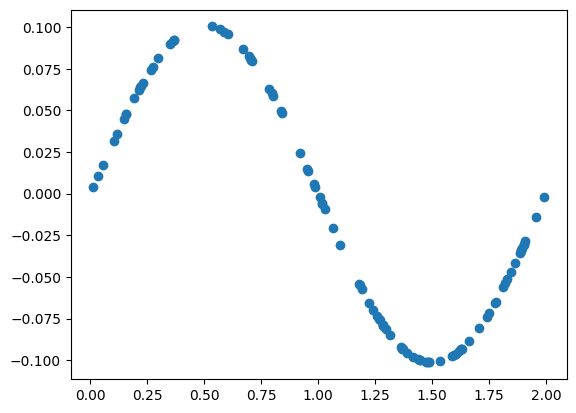

In [7]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

x=np.random.uniform(low=0.0, high=2.0, size=(100,1))

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True)
pt_u = net(pt_x)
u=pt_u.data.cpu().numpy()
plt.scatter(x, u)
plt.show() # Plot the analytical solution

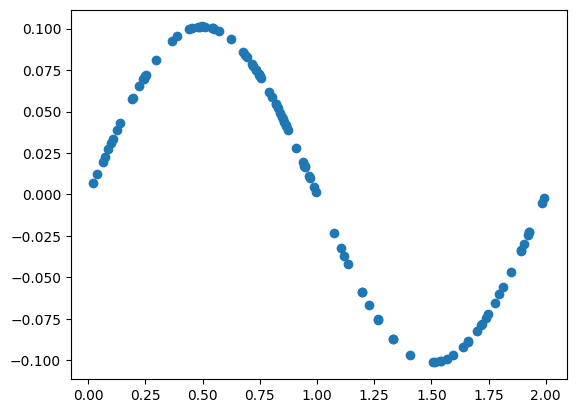

In [8]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

x=np.random.uniform(low=0.0, high=2.0, size=(100,1))

u=np.sin(np.pi*x)*(1/(np.pi**2))
plt.scatter(x, u)
plt.show()

To impose *directly* the boundary conditions (usually gives better training results) you have to: 
* impose the condition directly on the output of the forward law multiplying the output by a function that does the job!
In our case: to make the solution zero at $x = 0$ and $x = 2$, a good function is $x(x - 2)$. Thus ``x*(x - 2)*output``.
* Get rid of the Dirichlet cost: it is not needed anymore :)

See the lecture (15-04-2025) for more details for this solution. **BUT** notice that with this approach, the loss remain on an order of magnitude e-03, so it is a little bit worst that before.